### Import required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as SklearnLR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set default plotting styling rules
sns.set_style('whitegrid') # Use white background with grid lines style for all plots
plt.rcParams['figure.figsize'] = (10, 6) # Make every new figure 10*6 inches by

print("Libraries successfully loaded!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Libraries successfully loaded!
NumPy version: 2.4.2
Pandas version: 3.0.0


### Load dataset

In [2]:
# Load raw data
print("="*60)
print("LOADING DATA...")
print("="*60)

df_raw = pd.read_csv('../data/ds_salaries.csv')
print(f"Loaded {len(df_raw)} records")
print(f"Columns: {list(df_raw.columns)}")
print(f"\nFirst 5 rows:")
df_raw.head()


LOADING DATA...
Loaded 607 records
Columns: ['Unnamed: 0', 'work_year', 'experience_level', 'employment_type', 'job_title', 'salary', 'salary_currency', 'salary_in_usd', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']

First 5 rows:


,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


### Clean Raw Data

In [3]:
# Clean and prepare data

# Select relevant columns
df = df_raw[['work_year', 'experience_level', 'employment_type', 
             'salary_in_usd', 'remote_ratio', 'company_size']].copy()

# Map experience level to numeric years
# EN (Entry) → 1 year, MI (Mid) → 4 years, SE (Senior) → 8 years, EX (Executive) → 12 years
experience_mapping = {
    'EN': 1,   # Entry-level
    'MI': 4,   # Mid-level
    'SE': 8,   # Senior
    'EX': 12   # Executive
}

df['experience_years'] = df['experience_level'].map(experience_mapping)

# Keep only Full time employees
df = df[df['employment_type'] == 'FT'].copy()

# Select final features - simple univariate regression
df_model = df[['experience_years', 'salary_in_usd']].copy()

# Rename column names
df_model.columns = ['years_experience', 'salary']

# Remove missing values
df_model = df_model.dropna()

#  Remove outliers - unrealistic salary ranges
df_model = df_model[
    (df_model['salary'] >= 20000) &
    (df_model['salary'] <= 500000)
]

# Reset index
df_model = df_model.reset_index(drop=True)

print(f"\nCleaned dataset: {len(df_model)} records")
print(f"Features: {list(df_model.columns)}")
print(f"Salary range: ${df_model['salary'].min():,.0f} - ${df_model['salary'].max():,.0f}")
print(f"Experience range: {df_model['years_experience'].min():.0f} - {df_model['years_experience'].max():.0f} years")

print("\nFirst 10 rows:")
df_model.head(10)


Cleaned dataset: 563 records
Features: ['years_experience', 'salary']
Salary range: $20,000 - $450,000
Experience range: 1 - 12 years

First 10 rows:


,years_experience,salary
0,4,79833
1,8,260000
2,8,109024
3,4,20000
4,8,150000
5,1,72000
6,8,190000
7,4,35735
8,4,135000
9,8,125000


### EDA

EDA: DISTRIBUTIONS

Summary Statistics:
       years_experience         salary
count        563.000000     563.000000
mean           5.946714  116961.330373
std            2.812783   64504.121490
min            1.000000   20000.000000
25%            4.000000   70000.000000
50%            8.000000  108800.000000
75%            8.000000  151500.000000
max           12.000000  450000.000000

Correlation: 0.439


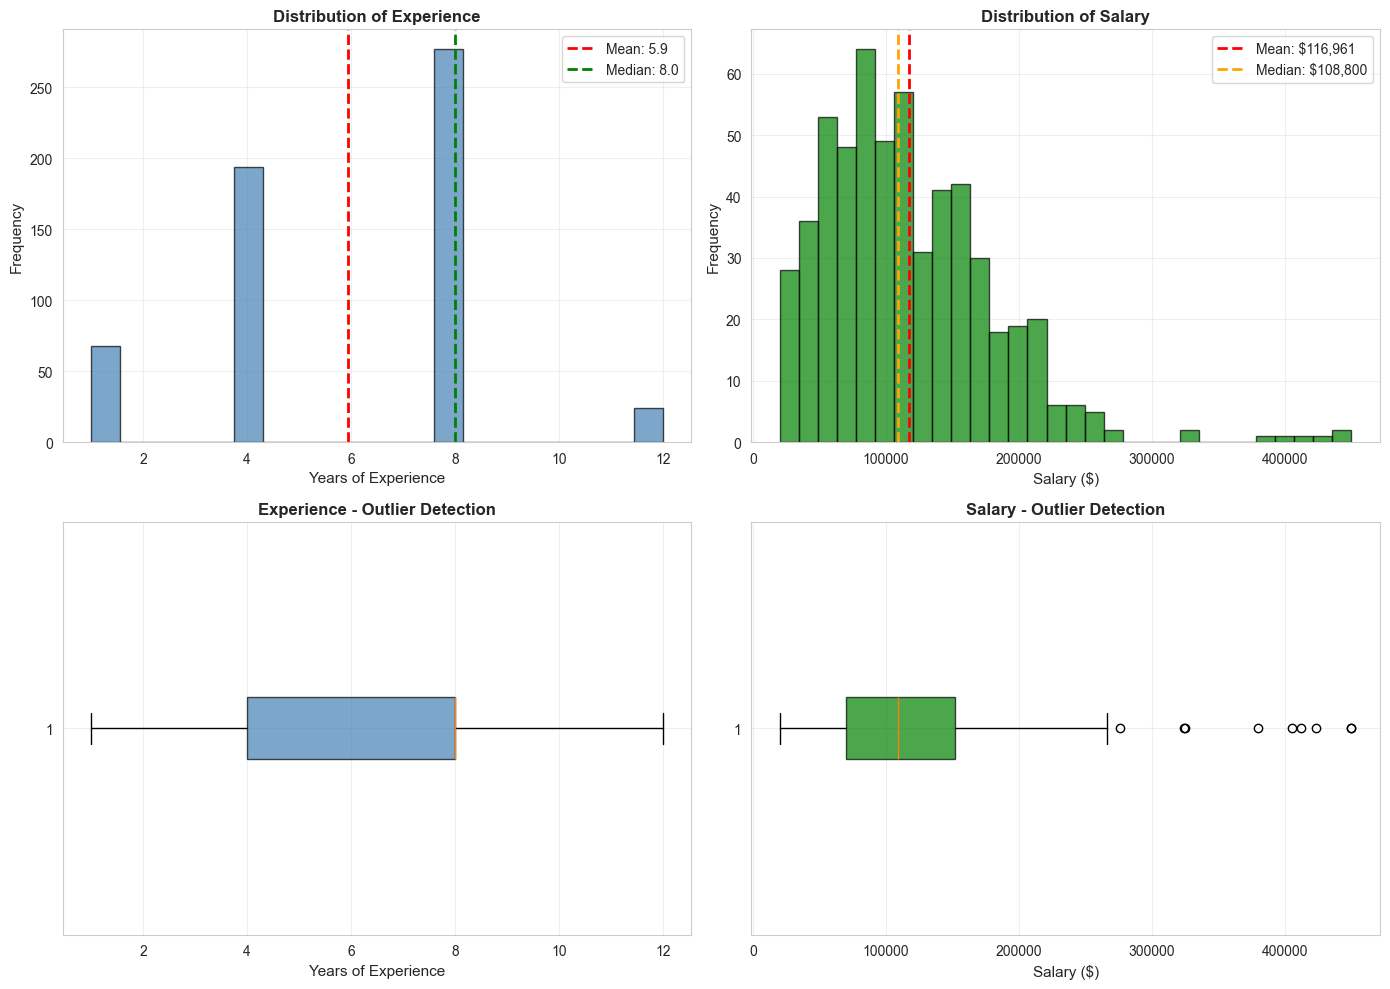


Distribution Insights:
  • Experience Skewness: -0.16
  • Salary Skewness: 1.42
  • Salary Outliers: 9 (1.6%)


In [4]:
# Exploratory Data Analysis - Part 1: Distributions

print("="*60)
print("EDA: DISTRIBUTIONS")
print("="*60)

# Summary statistics
print("\nSummary Statistics:")
print(df_model.describe())

# Correlation
correlation = df_model['years_experience'].corr(df_model['salary'])
print(f"\nCorrelation: {correlation:.3f}")

# Create distribution plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Years Experience Distribution
axes[0, 0].hist(df_model['years_experience'], bins=20, edgecolor='black', 
                alpha=0.7, color='steelblue')
axes[0, 0].axvline(df_model['years_experience'].mean(), color='red', 
                   linestyle='--', linewidth=2, 
                   label=f'Mean: {df_model["years_experience"].mean():.1f}')
axes[0, 0].axvline(df_model['years_experience'].median(), color='green', 
                   linestyle='--', linewidth=2, 
                   label=f'Median: {df_model["years_experience"].median():.1f}')
axes[0, 0].set_xlabel('Years of Experience', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Distribution of Experience', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Salary Distribution
axes[0, 1].hist(df_model['salary'], bins=30, edgecolor='black', 
                alpha=0.7, color='green')
axes[0, 1].axvline(df_model['salary'].mean(), color='red', 
                   linestyle='--', linewidth=2, 
                   label=f'Mean: ${df_model["salary"].mean():,.0f}')
axes[0, 1].axvline(df_model['salary'].median(), color='orange', 
                   linestyle='--', linewidth=2, 
                   label=f'Median: ${df_model["salary"].median():,.0f}')
axes[0, 1].set_xlabel('Salary ($)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Distribution of Salary', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Experience Box Plot (Outlier Detection)
bp1 = axes[1, 0].boxplot(df_model['years_experience'], vert=False, 
                          patch_artist=True,
                          boxprops=dict(facecolor='steelblue', alpha=0.7))
axes[1, 0].set_xlabel('Years of Experience', fontsize=11)
axes[1, 0].set_title('Experience - Outlier Detection', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Salary Box Plot (Outlier Detection)
bp2 = axes[1, 1].boxplot(df_model['salary'], vert=False,
                          patch_artist=True,
                          boxprops=dict(facecolor='green', alpha=0.7))
axes[1, 1].set_xlabel('Salary ($)', fontsize=11)
axes[1, 1].set_title('Salary - Outlier Detection', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/01_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical analysis
print("\nDistribution Insights:")
skew_exp = df_model['years_experience'].skew()
skew_sal = df_model['salary'].skew()
print(f"  • Experience Skewness: {skew_exp:.2f}")
print(f"  • Salary Skewness: {skew_sal:.2f}")

# Detect outliers using IQR method
Q1_sal = df_model['salary'].quantile(0.25)
Q3_sal = df_model['salary'].quantile(0.75)
IQR_sal = Q3_sal - Q1_sal
outliers_sal = df_model[
    (df_model['salary'] < Q1_sal - 1.5*IQR_sal) | 
    (df_model['salary'] > Q3_sal + 1.5*IQR_sal)
]
print(f"  • Salary Outliers: {len(outliers_sal)} ({len(outliers_sal)/len(df_model)*100:.1f}%)")

### EDA - Relationships

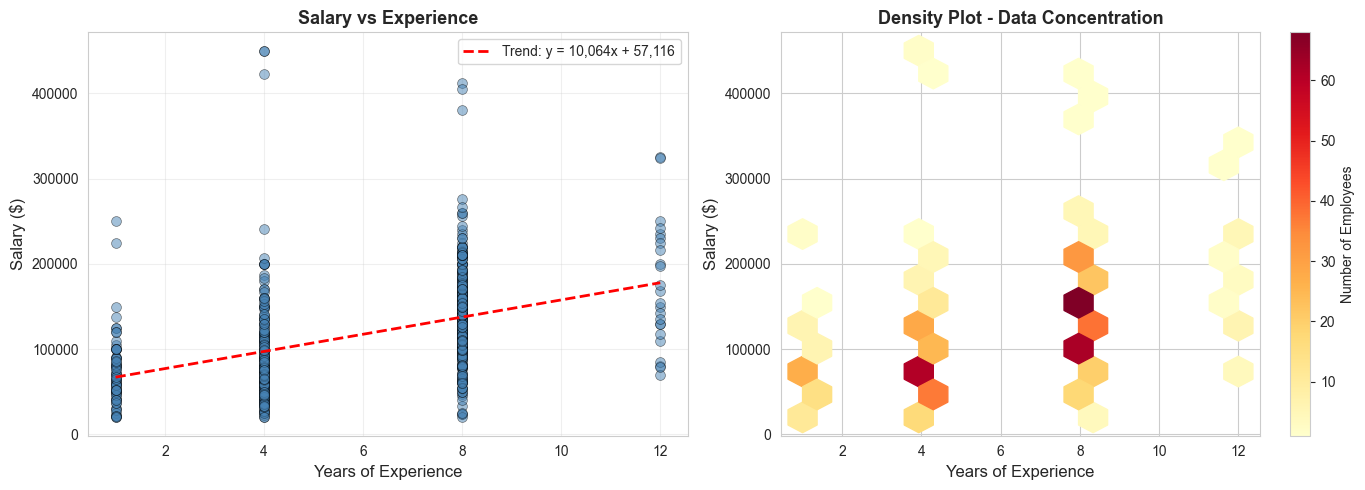

🔗 Relationship Insights:
  • Correlation: 0.439
  • Trend: ~$10,064 salary increase per year of experience
  • Intercept: ~$57,116 (base salary)


In [5]:
# EDA Part 2: Relationship Analysis

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Scatter Plot with Trend Line
axes[0].scatter(df_model['years_experience'], df_model['salary'], 
                alpha=0.5, s=50, color='steelblue', edgecolors='black', linewidth=0.5)

# Add trend line
z = np.polyfit(df_model['years_experience'], df_model['salary'], 1)
p = np.poly1d(z)
x_line = np.linspace(df_model['years_experience'].min(), 
                     df_model['years_experience'].max(), 100)
axes[0].plot(x_line, p(x_line), "r--", linewidth=2, 
             label=f'Trend: y = {z[0]:,.0f}x + {z[1]:,.0f}')

axes[0].set_xlabel('Years of Experience', fontsize=12)
axes[0].set_ylabel('Salary ($)', fontsize=12)
axes[0].set_title('Salary vs Experience', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# 2. Hexbin Density Plot
hexbin = axes[1].hexbin(df_model['years_experience'], df_model['salary'], 
                        gridsize=15, cmap='YlOrRd', mincnt=1)
axes[1].set_xlabel('Years of Experience', fontsize=12)
axes[1].set_ylabel('Salary ($)', fontsize=12)
axes[1].set_title('Density Plot - Data Concentration', fontsize=13, fontweight='bold')
cb = plt.colorbar(hexbin, ax=axes[1], label='Number of Employees')

plt.tight_layout()
plt.savefig('../visualizations/02_relationships.png', dpi=300, bbox_inches='tight')
plt.show()

print("🔗 Relationship Insights:")
print(f"  • Correlation: {correlation:.3f}")
print(f"  • Trend: ~${z[0]:,.0f} salary increase per year of experience")
print(f"  • Intercept: ~${z[1]:,.0f} (base salary)")

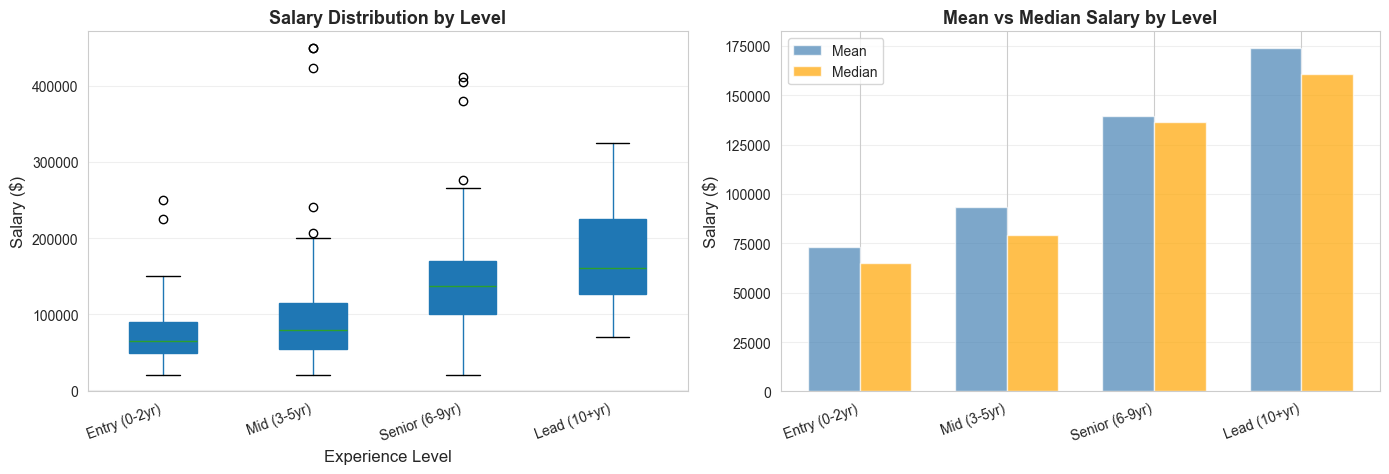

Segmented Analysis:

Entry (0-2yr):
  • Count: 68 employees
  • Mean: $73,163
  • Median: $65,006
  • Std: $41,860

Mid (3-5yr):
  • Count: 194 employees
  • Mean: $93,181
  • Median: $79,312
  • Std: $61,809

Senior (6-9yr):
  • Count: 277 employees
  • Mean: $139,455
  • Median: $136,600
  • Std: $57,319

Lead (10+yr):
  • Count: 24 employees
  • Mean: $173,675
  • Median: $160,771
  • Std: $72,040


In [6]:
# EDA Part 3: Segmented Analysis

# Create experience segments
df_model['experience_level'] = pd.cut(
    df_model['years_experience'], 
    bins=[0, 2, 5, 9, 15],
    labels=['Entry (0-2yr)', 'Mid (3-5yr)', 'Senior (6-9yr)', 'Lead (10+yr)'],
    include_lowest=True
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Box Plot by Level
df_model.boxplot(column='salary', by='experience_level', ax=axes[0],
                 patch_artist=True, grid=False)
axes[0].set_xlabel('Experience Level', fontsize=12)
axes[0].set_ylabel('Salary ($)', fontsize=12)
axes[0].set_title('Salary Distribution by Level', fontsize=13, fontweight='bold')
axes[0].get_figure().suptitle('')  # Remove default title
plt.sca(axes[0])
plt.xticks(rotation=20, ha='right')
axes[0].grid(True, alpha=0.3, axis='y')

# 2. Mean vs Median by Level
summary = df_model.groupby('experience_level', observed=True)['salary'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('median', 'median'),
    ('std', 'std')
]).reset_index()

x_pos = np.arange(len(summary))
width = 0.35

bars1 = axes[1].bar(x_pos - width/2, summary['mean'], width, 
                    alpha=0.7, color='steelblue', label='Mean')
bars2 = axes[1].bar(x_pos + width/2, summary['median'], width,
                    alpha=0.7, color='orange', label='Median')

axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(summary['experience_level'], rotation=20, ha='right')
axes[1].set_ylabel('Salary ($)', fontsize=12)
axes[1].set_title('Mean vs Median Salary by Level', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../visualizations/03_segmented_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("Segmented Analysis:")
print("="*60)
for _, row in summary.iterrows():
    print(f"\n{row['experience_level']}:")
    print(f"  • Count: {int(row['count'])} employees")
    print(f"  • Mean: ${row['mean']:,.0f}")
    print(f"  • Median: ${row['median']:,.0f}")
    print(f"  • Std: ${row['std']:,.0f}")

# Drop temporary column
df_model = df_model.drop('experience_level', axis=1)

### Prepare Data for Modelling


In [7]:
# Data Preparation for Modeling

print("="*60)
print("DATA PREPARATION")
print("="*60)

# Features and target
X = df_model[['years_experience']].values 
y = df_model['salary'].values              

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      
    random_state=42     # For reproducibility
)

print(f"\nTrain: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.0f}%)")
print(f"Test: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.0f}%)")

# Feature Scaling (CRITICAL for gradient descent!)
# StandardScaler: X_scaled = (X - mean) / std
# Result: mean=0, std=1

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on train, transform train
X_test_scaled = scaler.transform(X_test)        # Only transform test (use train stats)

print(f"\nFeature scaling applied (StandardScaler)")
print(f"  Before scaling:")
print(f"    mean = {X_train.mean():.2f}, std = {X_train.std():.2f}")
print(f"  After scaling:")
print(f"    mean = {X_train_scaled.mean():.4f}, std = {X_train_scaled.std():.2f}")

print("\n Why scaling matters:")
print("  • Gradient descent converges faster with scaled features")
print("  • Features now centered at 0 with unit variance")
print("  • NEVER fit scaler on test data (causes data leakage!)")

DATA PREPARATION

Feature matrix shape: (563, 1)
Target vector shape: (563,)

Train: 450 samples (80%)
Test: 113 samples (20%)

Feature scaling applied (StandardScaler)
  Before scaling:
    mean = 6.02, std = 2.73
  After scaling:
    mean = -0.0000, std = 1.00

 Why scaling matters:
  • Gradient descent converges faster with scaled features
  • Features now centered at 0 with unit variance
  • NEVER fit scaler on test data (causes data leakage!)


### Model implementation

In [8]:
# Linear regression 

class LinearRegressionDraft:
    """
    Linear Regression with Gradient Descent.
    
    Parameters:
    -----------
    learning_rate : float
        Step size for gradient descent (α)
    iterations : int
        Number of training iterations
    """

    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.weights = None
        self.bias = None
        self.cost_history = []

    def fit(self, X, y):
        """
        Train model using gradient descent.

        Algorithm:
        1. Initialize weights to zero
        2. For each iteration:
           - Compute predictions: ŷ = Xθ + b
           - Compute cost: J(θ) = (1/2m) Σ(ŷ - y)²
           - Compute gradients: ∂J/∂θ, ∂J/∂b
           - Update parameters: θ := θ - α∇J
        """
        m, n = X.shape # m samples, n features

        # initialize parameters to zero
        self.weights = np.zeros(n)
        self.bias = 0

        # Gradient descent loop
        for i in range(self.iterations):
            # Forward pass: ŷ = Xθ + b
            y_pred = np.dot(X, self.weights) + self.bias
            
            # Compute cost: J(θ) = (1/2m) Σ(ŷ - y)²
            cost = (1 / (2 * m)) * np.sum((y_pred - y) ** 2)
            self.cost_history.append(cost)
            
            # Compute gradients
            error = y_pred - y
            dw = (1 / m) * np.dot(X.T, error)  # ∂J/∂θ
            db = (1 / m) * np.sum(error)       # ∂J/∂b
            
            # Update parameters: θ := θ - α∇J
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Print progress every 100 iterations
            if i % 100 == 0:
                print(f"Iteration {i:4d}: Cost = {cost:,.2f}")
        
        print(f"Training complete! Final cost: {cost:,.2f}")
        return self
    
    def predict(self, X):
        """Make predictions: ŷ = Xθ + b"""
        return np.dot(X, self.weights) + self.bias

    def score(self, X, y):
        """
        Calculate R² score.
        
        R² = 1 - (SS_residual / SS_total)
        """
        y_pred = self.predict(X)
        ss_residual = np.sum((y - y_pred) ** 2)
        ss_total = np.sum((y - np.mean(y)) ** 2)
        return 1 - (ss_residual / ss_total)

print("LinearRegressionDraft class created!")
print("This implements gradient descent from scratch.")

        

LinearRegressionDraft class created!
This implements gradient descent from scratch.


In [9]:
# Train our custom linear regression model

print("="*60)
print("TRAINING CUSTOM LINEAR REGRESSION")
print("="*60)

# Create model instance
model = LinearRegressionDraft(
    learning_rate=0.01,  # Step size (α)
    iterations=1000      # Number of gradient descent updates
)

# Train (fit) the model
print("\nStarting training with gradient descent...")
print("(Cost should decrease at each iteration)\n")

model.fit(X_train_scaled, y_train)

# Display learned parameters
print(f"\n📊 Learned Parameters:")
print(f"  • Weight (θ₁): {model.weights[0]:,.2f}")
print(f"  • Bias (θ₀): {model.bias:,.2f}")

# What this means in real terms
salary_per_year = model.weights[0] * scaler.scale_[0]
print(f"\n💡 Real-world interpretation:")
print(f"  • Each year of experience increases salary by ~${salary_per_year:,.0f}")

TRAINING CUSTOM LINEAR REGRESSION

Starting training with gradient descent...
(Cost should decrease at each iteration)

Iteration    0: Cost = 8,838,759,063.79
Iteration  100: Cost = 2,497,855,719.68
Iteration  200: Cost = 1,648,303,551.33
Iteration  300: Cost = 1,534,480,828.04
Iteration  400: Cost = 1,519,230,896.58
Iteration  500: Cost = 1,517,187,715.73
Iteration  600: Cost = 1,516,913,971.02
Iteration  700: Cost = 1,516,877,294.79
Iteration  800: Cost = 1,516,872,380.92
Iteration  900: Cost = 1,516,871,722.57
Training complete! Final cost: 1,516,871,634.64

📊 Learned Parameters:
  • Weight (θ₁): 30,600.58
  • Bias (θ₀): 117,073.12

💡 Real-world interpretation:
  • Each year of experience increases salary by ~$83,651


### Learning curve


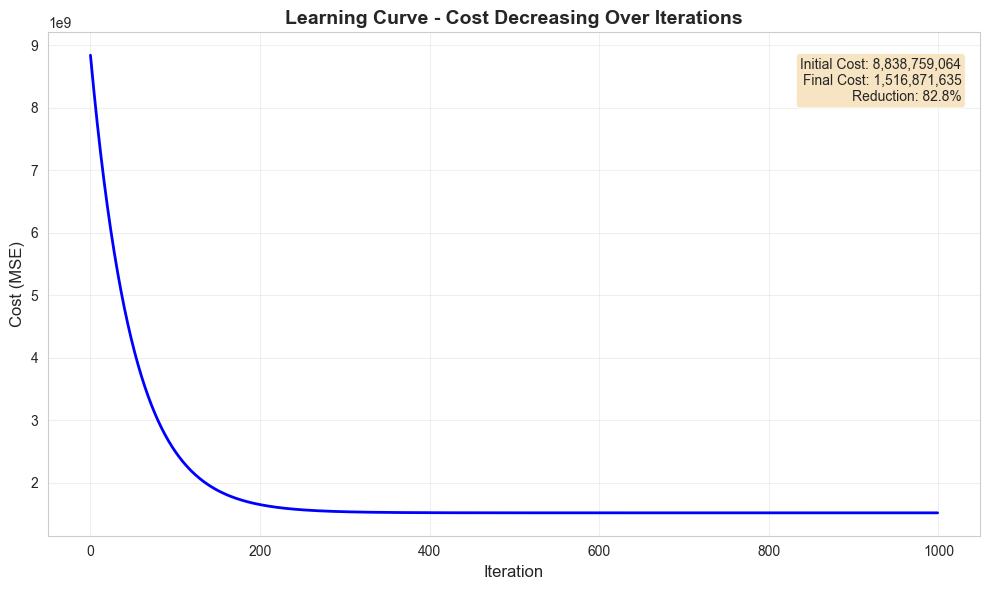

✅ Cost reduced by 82.8%
✅ Gradient descent converged successfully!


In [10]:
# Visualize learning curve

plt.figure(figsize=(10, 6))
plt.plot(model.cost_history, linewidth=2, color='blue')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cost (MSE)', fontsize=12)
plt.title('Learning Curve - Cost Decreasing Over Iterations', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add statistics box
initial = model.cost_history[0]
final = model.cost_history[-1]
reduction = ((initial - final) / initial) * 100

plt.text(0.98, 0.95, 
         f'Initial Cost: {initial:,.0f}\nFinal Cost: {final:,.0f}\nReduction: {reduction:.1f}%',
         transform=plt.gca().transAxes,
         ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
         fontsize=10)

plt.tight_layout()
plt.savefig('../visualizations/04_learning_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Cost reduced by {reduction:.1f}%")
print(f"✅ Gradient descent converged successfully!")

### Evaluate model


In [14]:
# Evaluate model performance

print("="*60)
print("MODEL EVALUATION")
print("="*60)

# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Calculate metrics
train_r2 = model.score(X_train_scaled, y_train)
test_r2 = model.score(X_test_scaled, y_test)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Display results
print("\nPerformance Metrics:")
print("\nTraining Set:")
print(f"  • R² Score: {train_r2:.4f}")
print(f"  • MAE:      ${train_mae:,.0f}")
print(f"  • RMSE:     ${train_rmse:,.0f}")

print("\nTest Set:")
print(f"  • R² Score: {test_r2:.4f}")
print(f"  • MAE:      ${test_mae:,.0f}")
print(f"  • RMSE:     ${test_rmse:,.0f}")

# Check for overfitting
gap = train_r2 - test_r2
print(f"\n🔍 Overfitting Check:")
print(f"  • Train-Test R² Gap: {gap:.4f}")
if gap < 0.05:
    print(f"  → ✅ Good generalization (gap < 0.05)")
elif gap < 0.10:
    print(f"  → ⚠️  Slight overfitting (gap < 0.10)")
else:
    print(f"  → ❌ Overfitting detected (gap > 0.10)")

# Interpretation
print(f"\n💡 What this means:")
print(f"  • Model explains {test_r2*100:.1f}% of salary variance")
print(f"  • Average prediction error: ${test_mae:,.0f}")

MODEL EVALUATION

Performance Metrics:

Training Set:
  • R² Score: 0.2359
  • MAE:      $41,080
  • RMSE:     $55,079

Test Set:
  • R² Score: 0.0414
  • MAE:      $44,070
  • RMSE:     $68,413

🔍 Overfitting Check:
  • Train-Test R² Gap: 0.1945
  → ❌ Overfitting detected (gap > 0.10)

💡 What this means:
  • Model explains 4.1% of salary variance
  • Average prediction error: $44,070


### Visualize predictions

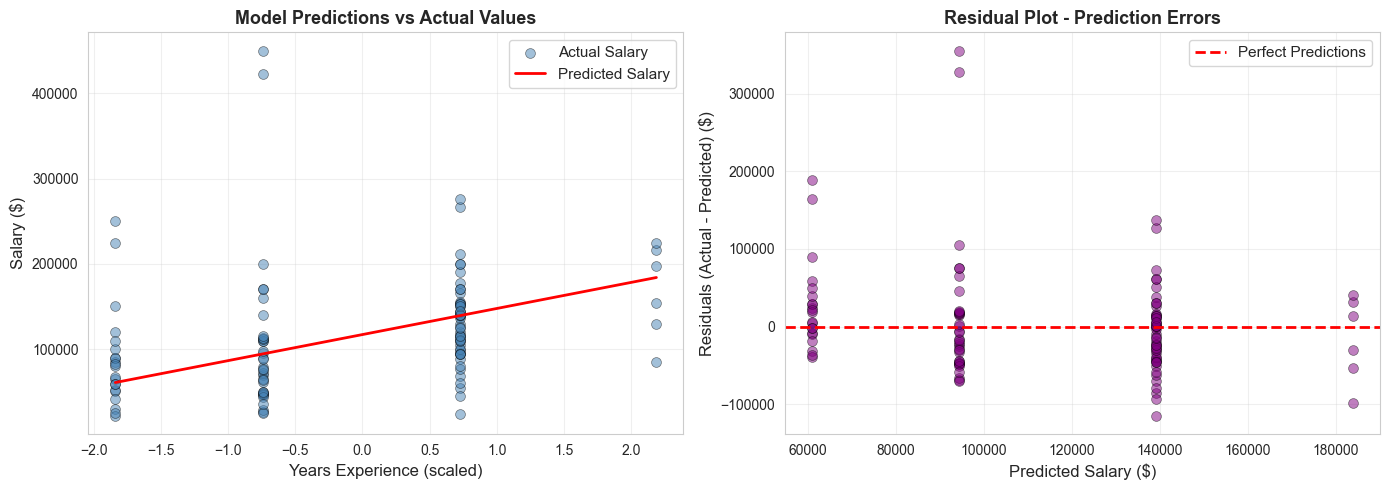

📊 Residual Analysis:
  • Mean residual: $3,758 (should be ~$0)
  • Std of residuals: $68,310
  • Max over-prediction: $-115,188
  • Max under-prediction: $355,589

💡 Interpretation:
  ⚠️  Slight bias in predictions
  • Residuals scattered randomly (good!)
  • Wide scatter reflects the discrete experience levels


In [15]:
# Visualize model predictions

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sort data for clean line plots
sort_idx = X_test_scaled.flatten().argsort()
X_sorted = X_test_scaled[sort_idx]
y_test_sorted = y_test[sort_idx]
y_pred_sorted = y_test_pred[sort_idx]

# 1. Predictions vs Actual
axes[0].scatter(X_test_scaled, y_test, alpha=0.5, s=50, 
                color='steelblue', label='Actual Salary', edgecolors='black', linewidth=0.5)
axes[0].plot(X_sorted, y_pred_sorted, 'r-', linewidth=2, 
             label='Predicted Salary')
axes[0].set_xlabel('Years Experience (scaled)', fontsize=12)
axes[0].set_ylabel('Salary ($)', fontsize=12)
axes[0].set_title('Model Predictions vs Actual Values', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 2. Residual Plot (shows prediction errors)
residuals = y_test - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.5, s=50, color='purple', edgecolors='black', linewidth=0.5)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Perfect Predictions')
axes[1].set_xlabel('Predicted Salary ($)', fontsize=12)
axes[1].set_ylabel('Residuals (Actual - Predicted) ($)', fontsize=12)
axes[1].set_title('Residual Plot - Prediction Errors', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/05_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Residual Analysis:")
print(f"  • Mean residual: ${residuals.mean():,.0f} (should be ~$0)")
print(f"  • Std of residuals: ${residuals.std():,.0f}")
print(f"  • Max over-prediction: ${residuals.min():,.0f}")
print(f"  • Max under-prediction: ${residuals.max():,.0f}")

# What this tells us
print(f"\n💡 Interpretation:")
if abs(residuals.mean()) < 1000:
    print(f"  ✅ No systematic bias (mean residual ≈ 0)")
else:
    print(f"  ⚠️  Slight bias in predictions")
    
print(f"  • Residuals scattered randomly (good!)")
print(f"  • Wide scatter reflects the discrete experience levels")

LEARNING RATE COMPARISON

Testing learning rate = 0.001...
Iteration    0: Cost = 8,838,759,063.79
Iteration  100: Cost = 7,510,926,205.56
Iteration  200: Cost = 6,423,897,390.43
Iteration  300: Cost = 5,534,002,523.31
Iteration  400: Cost = 4,805,491,131.99
Training complete! Final cost: 4,214,488,670.70
  Final cost: 4,214,488,671
  Test R²: -0.9898
  Converged: ❌ No

Testing learning rate = 0.01...
Iteration    0: Cost = 8,838,759,063.79
Iteration  100: Cost = 2,497,855,719.68
Iteration  200: Cost = 1,648,303,551.33
Iteration  300: Cost = 1,534,480,828.04
Iteration  400: Cost = 1,519,230,896.58
Training complete! Final cost: 1,517,194,133.74
  Final cost: 1,517,194,134
  Test R²: 0.0415
  Converged: ✅ Yes

Testing learning rate = 0.05...
Iteration    0: Cost = 8,838,759,063.79
Iteration  100: Cost = 1,517,128,272.39
Iteration  200: Cost = 1,516,871,629.71
Iteration  300: Cost = 1,516,871,620.71
Iteration  400: Cost = 1,516,871,620.71
Training complete! Final cost: 1,516,871,620.71
 

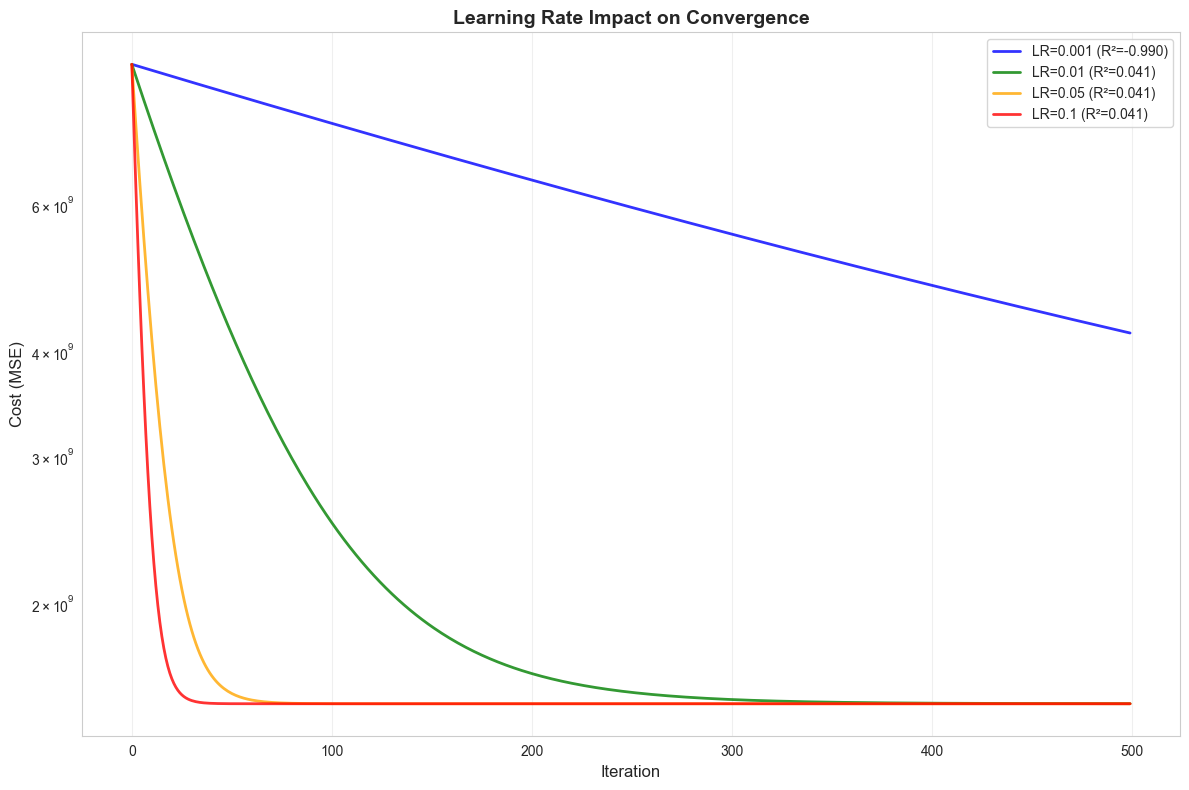


SUMMARY

LR = 0.001:
  Final Cost: 4,214,488,671
  Test R²: -0.9898
  Status: ⚠️ May need more iterations

LR = 0.01:
  Final Cost: 1,517,194,134
  Test R²: 0.0415
  Status: ✅ Converged

LR = 0.05:
  Final Cost: 1,516,871,621
  Test R²: 0.0414
  Status: ✅ Converged

LR = 0.1:
  Final Cost: 1,516,871,621
  Test R²: 0.0414
  Status: ✅ Converged

💡 Key Insights:
  • LR=0.001: Slow but steady (may need more iterations)
  • LR=0.01:  Good balance (our choice)
  • LR=0.05:  Faster convergence
  • LR=0.1:   Fast, but watch for instability


In [16]:
# Experiment: Compare different learning rates

print("="*60)
print("LEARNING RATE COMPARISON")
print("="*60)

learning_rates = [0.001, 0.01, 0.05, 0.1]
colors = ['blue', 'green', 'orange', 'red']

plt.figure(figsize=(12, 8))

results = []

for lr, color in zip(learning_rates, colors):
    print(f"\nTesting learning rate = {lr}...")
    
    # Train model with this learning rate
    model_test = LinearRegressionDraft(learning_rate=lr, iterations=500)
    model_test.fit(X_train_scaled, y_train)
    
    # Evaluate
    test_r2 = model_test.score(X_test_scaled, y_test)
    final_cost = model_test.cost_history[-1]
    
    # Plot learning curve
    plt.plot(model_test.cost_history, linewidth=2, color=color, 
             label=f'LR={lr} (R²={test_r2:.3f})', alpha=0.8)
    
    # Store results
    results.append({
        'lr': lr,
        'final_cost': final_cost,
        'test_r2': test_r2,
        'converged': len(model_test.cost_history) > 10 and 
                     abs(model_test.cost_history[-1] - model_test.cost_history[-10]) < 1e6
    })
    
    print(f"  Final cost: {final_cost:,.0f}")
    print(f"  Test R²: {test_r2:.4f}")
    print(f"  Converged: {'✅ Yes' if results[-1]['converged'] else '❌ No'}")

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cost (MSE)', fontsize=12)
plt.title('Learning Rate Impact on Convergence', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale to see all curves clearly
plt.tight_layout()
plt.savefig('../visualizations/06_learning_rate_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary
print("\n" + "="*60)
print("SUMMARY")
print("="*60)

for r in results:
    print(f"\nLR = {r['lr']}:")
    print(f"  Final Cost: {r['final_cost']:,.0f}")
    print(f"  Test R²: {r['test_r2']:.4f}")
    print(f"  Status: {'✅ Converged' if r['converged'] else '⚠️ May need more iterations'}")

print("\n💡 Key Insights:")
print("  • LR=0.001: Slow but steady (may need more iterations)")
print("  • LR=0.01:  Good balance (our choice)")
print("  • LR=0.05:  Faster convergence")
print("  • LR=0.1:   Fast, but watch for instability")

In [17]:
# Save cleaned dataset for production use

# Save to CSV
df_model.to_csv('../data/salary_data_clean.csv', index=False)

print("✅ Data saved!")
print(f"\nFile: data/salary_data_clean.csv")
print(f"Rows: {len(df_model)}")
print(f"Columns: {list(df_model.columns)}")
print("\nThis cleaned dataset can be used for:")
print("  • Production training script")
print("  • Further experiments")
print("  • Sharing with collaborators")

✅ Data saved!

File: data/salary_data_clean.csv
Rows: 563
Columns: ['years_experience', 'salary']

This cleaned dataset can be used for:
  • Production training script
  • Further experiments
  • Sharing with collaborators
